My attempt to classify all the images

In [35]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pydot
import json

from PIL import Image

Loading the data from the folders

In [2]:
image_path = "cropped_images"
image_size = (100,100)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"{image_path}/training",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,

)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"{image_path}/validation",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
)


Found 48610 files belonging to 2 classes.
Using 38888 files for training.


2022-05-02 17:17:22.675237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 17:17:22.675266: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 17:17:22.675282: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-05-02 17:17:22.676326: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 6320 files belonging to 2 classes.
Using 1264 files for validation.


Visualize 9 observations

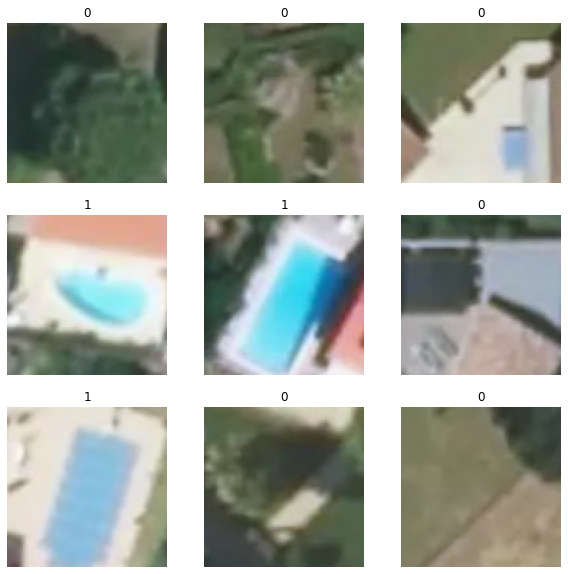

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


Define some data augmentation given that there are not too many images

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


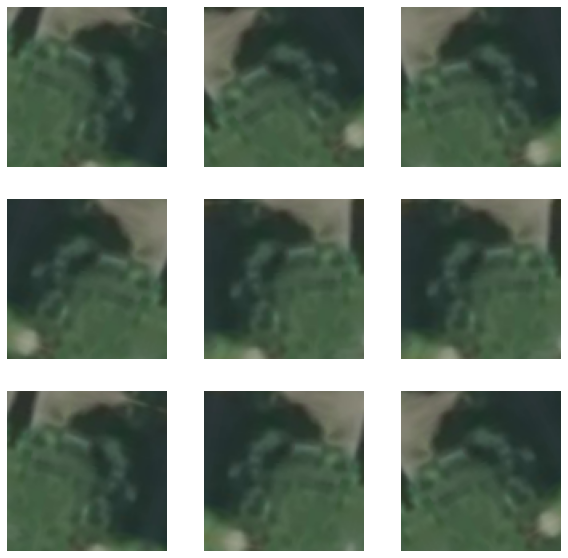

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


Configure the dataset for performance

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


Build the model

In [4]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Train the model

In [25]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50


2022-04-27 13:33:07.040383: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.
2022-04-27 13:33:07.107500: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.
2022-04-27 13:33:07.155529: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.
2022-04-27 13:33:07.198179: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.
2022-04-27 13:33:07.260076: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40960000 exceeds 10% of free system memory.


1216/1216 [==============================] - 1740s 1s/step - loss: 0.1450 - accuracy: 0.9560 - val_loss: 0.1526 - val_accuracy: 0.9533
Epoch 2/50
1216/1216 [==============================] - 1760s 1s/step - loss: 0.1245 - accuracy: 0.9640 - val_loss: 0.1546 - val_accuracy: 0.9494
Epoch 3/50
1216/1216 [==============================] - 1792s 1s/step - loss: 0.1184 - accuracy: 0.9655 - val_loss: 0.1587 - val_accuracy: 0.9399
Epoch 4/50
1216/1216 [==============================] - 1686s 1s/step - loss: 0.1136 - accuracy: 0.9664 - val_loss: 0.1068 - val_accuracy: 0.9612
Epoch 5/50
1216/1216 [==============================] - 1653s 1s/step - loss: 0.1100 - accuracy: 0.9680 - val_loss: 0.1554 - val_accuracy: 0.9391
Epoch 6/50
1216/1216 [==============================] - 1682s 1s/step - loss: 0.1075 - accuracy: 0.9675 - val_loss: 0.1319 - val_accuracy: 0.9533
Epoch 7/50
1216/1216 [==============================] - 1681s 1s/step - loss: 0.1054 - accuracy: 0.9681 - val_loss: 0.1222 - val_accura

Load the model

In [5]:
checkpoint_path = f"models/save_at_50.h5"

model.load_weights(checkpoint_path)

Input a new image to the model

In [36]:
with open('metadata.json') as f:
    coords = json.load(f)

filenames = list(coords.keys())

def get_pixels_range(bounds_x_y):
    min_x = 512
    max_x = 0
    min_y = 512
    max_y = 0

    for coords in bounds_x_y:
        if coords["x"] > max_x: max_x = coords["x"]
        if coords["x"] < min_x: min_x = coords["x"]
        if coords["y"] > max_y: max_y = coords["y"]
        if coords["y"] < min_y: min_y = coords["y"]

    return [int(x) for x in [np.floor(min_x), np.ceil(max_x), np.floor(min_y), np.ceil(max_y)]]
    

Let see how it works for a given image with given coordinates

In [41]:
image_name = filenames[123]
min_x, max_x, min_y,max_y = get_pixels_range(coords[image_name]["bounds_x_y"])
im = Image.open(f"images/{image_name}", "r")

test_img_path = "test_image.png"

pixels = im.load()

all_pixels = []
for height in range(10,110):
    for width in range(20, 120):
        cpixel = pixels[width, height]
        all_pixels.append(cpixel)

img = Image.new('RGB', (100,100))
img.putdata(all_pixels)
img.show()

# image_array  =tf.keras.preprocessing.image.load_img(test_img_path,image_size=)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [42]:
predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent non pool and %.2f percent pool."
    % (100 * (1 - score), 100 * score)
)

This image is 99.33 percent non pool and 0.67 percent pool.


Now lets try to fina a pool using the largest probability

In [65]:
image_name = filenames[310]
im = Image.open(f"images/{image_name}", "r")
pixels = im.load()

best_image = ""
best_prob = 0.0

for y_coord in range(0,401, 100):
    for x_coord in range(0,401, 100):
        all_pixels = []
        for height in range(y_coord,y_coord+100):
            for width in range(x_coord, x_coord+100):
                cpixel = pixels[width, height]
                all_pixels.append(cpixel)

        img = Image.new('RGB', (100,100))
        img.putdata(all_pixels)

        # image_array  =tf.keras.preprocessing.image.load_img(test_img_path,image_size=)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)
        score = predictions[0]
        if score > best_prob:
            best_prob = score
            best_image = img
            best_x, best_y = x_coord, y_coord

In [66]:
for x in range(best_x, best_x + 100):
    im.putpixel( (x,best_y), (255,0, 0))
    im.putpixel( (x,best_y+100), (255,0, 0))

for y in range(best_y, best_y + 100):
    im.putpixel( (best_x, y), (255,0, 0))
    im.putpixel( (best_x+100, y), (255,0, 0))

im.show()
print(
    "This image is %.2f percent non pool and %.2f percent pool."
    % (100 * (1 - best_prob), 100 * best_prob)
)

This image is 0.26 percent non pool and 99.74 percent pool.
